# "Just in time GUIs" for interactive exploration

## Bridging JavaScript and the IPython kernel in the browser

In this exercise we illustrate IPython's interactive capabilities by building an image comparison tool, inspired by [Github's image diff](https://github.com/blog/817-behold-image-view-modes).

We will see how we can build, with a very limited amount of code, a small tool to assist us in comparing two related images visually, a task often needed in data analysis.  While working interactively with code, most of us probably simply will plot both next to each other and look at them side by side...

Since this example was written as an illustration for a recent talk at [Neil Lawrence's Data Science and Machine Learning initiative at U. Sheffield](http://staffwww.dcs.shef.ac.uk/people/N.Lawrence/), we'll use for our illustration the old and new version of the coat of arms for the University of Sheffield:

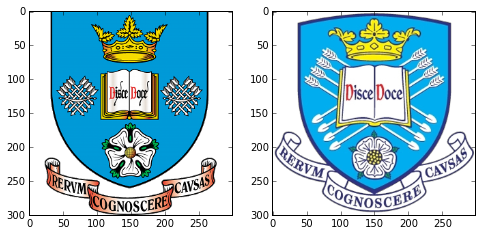

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

a = plt.imread("University_of_Sheffield_coat_of_arms_old.png")
b = plt.imread("University_of_Sheffield_coat_of_arms_new.png")
plt.rcParams['figure.figsize'] = (8,6)
fig, (ax_a, ax_b) = plt.subplots(1, 2)
ax_a.imshow(a)
ax_b.imshow(b);

It would be great to be able to visualize the changes in various forms: as an image difference, blending the two, superimposing them... 

Let's build a set of comparison functions that will return a new image $c = f(a, b)$, so we can display the result. More generically, how we produce the comparison between $a$ and $b$ can depend on a parameter, say $\alpha$, so our comparison functions in general will be of the form $c = f(a, b, \alpha)$.

This is precisely the functionality offered by [Github's image diff tools](https://github.com/blog/817-behold-image-view-modes):

In [2]:
def c_blend(a, b, alpha):
    """Blend images a and b.
    """
    return (1.0-alpha)*a + alpha*b


def c_diff(a, b, alpha):
    """Return the difference between a and b.
    """
    # Note: we still leave alpha as a parameter for reasons
    # so we can call this function with the same interface as the others
    return a-b


def c_horizontal_shade(a, b, alpha):
    """Form c from top rows of a and bottom rows of b.
    """
    nrows = a.shape[0]
    r_index = int(alpha*nrows)
    c = np.empty_like(a)
    c[:r_index] = a[:r_index]
    c[r_index:] = b[r_index:]
    return c


def c_vertical_shade(a, b, alpha):
    """Form c from left columns of a and right columns of b.
    """
    ncols = a.shape[1]
    c_index = int(alpha*ncols)
    c = np.empty_like(a)   
    c[:, :c_index] = a[:, :c_index]
    c[:, c_index:] = b[:, c_index:]
    return c

Now that we have defined all our specific comparison functions, we can call any of them via a wrapper utility function that selects which one to uses, and ensures that the color limits are always the actual limiting values of the orginal data. Let's define this utility:

In [3]:
def compare(a, b, method=c_vertical_shade, alpha=0.5):
    """Show the comparison between images a and b using the 
    selected comparison method.
    """
    c = method(a, b, alpha)
    cmin = min(a.min(), b.min())
    cmax = max(a.max(), b.max())
    plt.imshow(c, clim=(cmin, cmax))

And using it, we can now call it as follows:

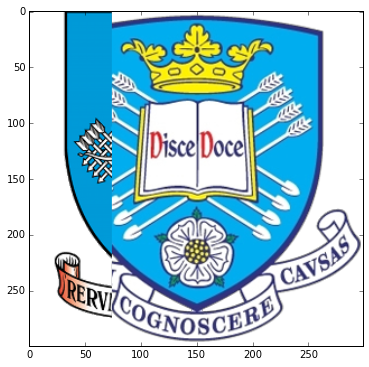

In [4]:
compare(a, b, alpha=0.250)

Or for example:

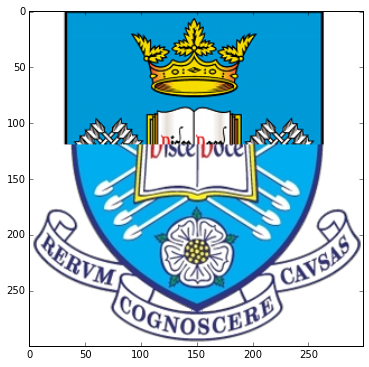

In [5]:
compare(a, b, c_horizontal_shade, 0.4)

# Exercise

Now, using the IPython `interact` facility, you should create a graphical interface to call `compare` with a slider for `alpha` between 0 and 1, and a selector for all the possible comparison methods.

# Solution

Using the IPython `interact` facility, we can provide interactive controls that let us much more easily see these differences:

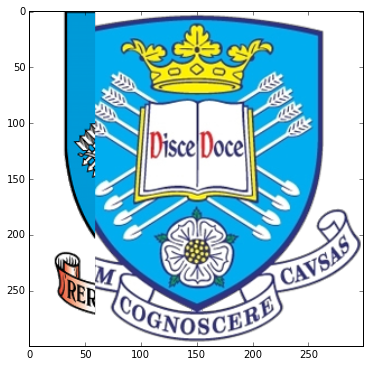

In [6]:
from ipywidgets import interact, fixed

interact(compare, a=fixed(a), b=fixed(b), alpha=(0.0, 1.0), 
         method=dict(blend=c_blend, diff=c_diff, 
                     horizontal_shade=c_horizontal_shade,
                     vertical_shade=c_vertical_shade));

## Building a slightly more feature-rich version

The above illustrates the basic idea and is already useful. With only a small amount more work, we can turn this into a richer tool that can come in handy any time we want to compare two images.

In [7]:
def ax3_show(axes, images):
    """Show three images on three axes with a common color range.
    """
    a, b = images[:2]
    cmin = min(a.min(), b.min())
    cmax = max(a.max(), b.max())

    for ax, im in zip(axes, images):
        ax.imshow(im, clim=(cmin, cmax))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.subplots_adjust(0, 0, 1, 1, 0, 0)

    
def show3_square(a, b, c, fig_width = 8):
    """Show three images for which a roughly square aspect ratio layout works.
    """
    # Compute the figure size to accomodate comparison image and originals
    nr, nc = c.shape[:2]
    ar = nr/nc
    fig_height = (2/3)*fig_width*ar
    f = plt.figure(None, (fig_width, fig_height) )
    # For some reason, I'm not getting the images to line up at the bottom. Puzzled.
    ax_c = f.add_axes((0, 0, 2/3, 1))
    ax_a = f.add_axes((2/3, 0, 1/3, 1/2))
    ax_b = f.add_axes((2/3, 1/2, 1/3, 1/2))

    # Put each image into its own axis
    ax3_show([ax_a, ax_b, ax_c], [a, b, c])
    
    
def show3_stack(a, b, c, mode='tall'):
    """Show three images stacked in the tall or wide direction.
    """
    shape = (1, 3) if mode=='tall' else (3, 1)
    f, ax = plt.subplots(*shape, sharex=True, sharey=True, figsize=(7, 5))
    ax3_show(ax, [c, a, b])
    
    
def show3(a, b, c, layout='auto'):
    """Show three images.
    
    The layout can be specified or left for automatic selection. If `layout`
    is `auto`, the aspect ratio of the images will be used to select the 
    best layout (tall, wide or square).
    """
    funcs = dict(square = show3_square,
                 tall = lambda a,b,c: show3_stack(a,b,c, 'tall'),
                 wide = lambda a,b,c: show3_stack(a,b,c, 'wide'))
    
    if layout == 'auto':
        nr, nc = c.shape[:2]
        ar = nr/nc
        if ar > 3:
            layout = 'tall'
        elif ar < 1/3:
            layout = 'wide'
        else:
            layout = 'square'
            
    show = funcs[layout]
    show(a, b, c)

Let's see what these three layout options look like:

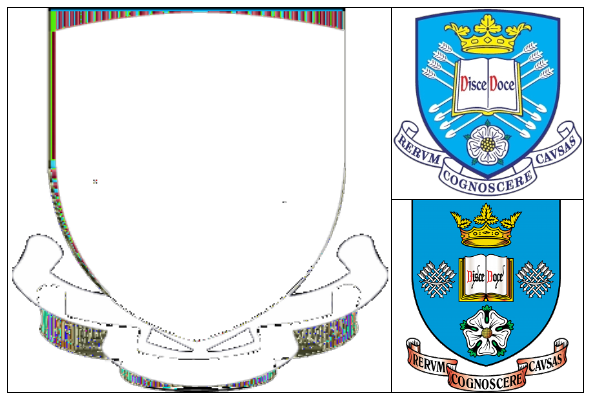

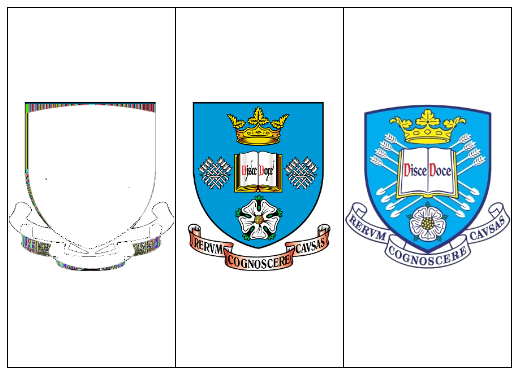

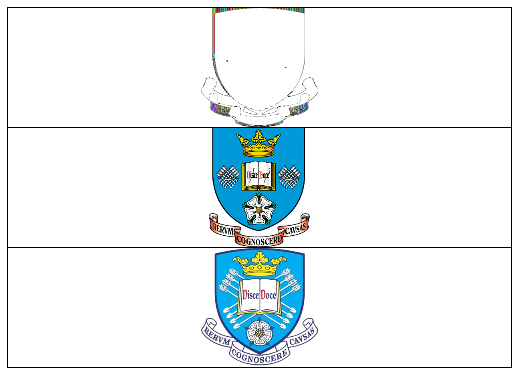

In [8]:
c = a-b
for layout in ['square', 'tall', 'wide']:
    show3(a, b, c, layout)

Now, we have all the pieces we need to build a better image comparison tool.

First, we build a pure function that takes the arguments we will want to control interactively, including the option to easily swap $a$ and $b$:

In [9]:
def compare2(a, b, method=c_vertical_shade, alpha=0, layout='auto', swap=False):
    """Utility function to compare two images.
    """
    if swap:
        a, b = b, a
    c = method(a, b, alpha)
    show3(a, b, c, layout=layout)    

And now, it's easy to build our interactive widget:

In [10]:
def imcompare(a, b):
    """Compare images a and b with interactive controls.
    """
    # Exercise: add support for cropping images to a common size if
    # they have a size mismatch.
    if a.shape != b.shape:
        raise ValueError("Both images must have the exact same shape")
        
    # Now, call compare2 above with an interactive widget
    interact(compare2, a=fixed(a), b=fixed(b),
             method=dict(blend=c_blend, diff=c_diff, 
                         horizontal_shade=c_horizontal_shade,
                         vertical_shade=c_vertical_shade),
                         alpha=(0.0, 1.0, 0.05),
                         swap=False,
                         layout=['auto', 'tall', 'wide']) 

With this widget, it's now simply a matter of making a function call any time we want to compare two images:

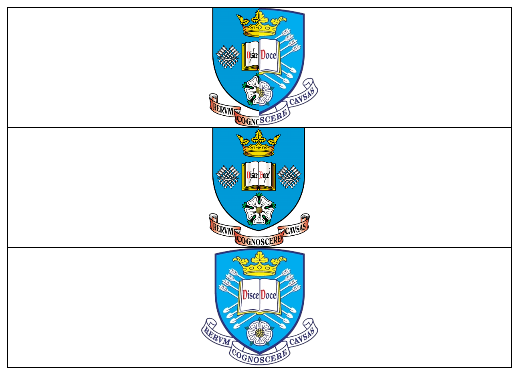

In [11]:
imcompare(a, b)